In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, ResNet50V2
from tensorflow.keras.layers import Dropout, Conv2D, Dense, MaxPool2D, Flatten

In [45]:
data_dir = "/content/drive/MyDrive/dataset-2/train/"
train_csv_df = pd.read_csv("/content/drive/MyDrive/dataset-2/train.csv")

##VGG16

In [ ]:
train_csv_df['img_path'] = train_csv_df.apply(lambda row : data_dir + str(row['Id']) + '.jpg', axis=1)
train_csv_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/drive/MyDrive/dataset-2/train/0007de1...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/drive/MyDrive/dataset-2/train/0009c66...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/drive/MyDrive/dataset-2/train/0013fd9...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/drive/MyDrive/dataset-2/train/0018df3...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/drive/MyDrive/dataset-2/train/001dc95...


In [ ]:
file_path = train_csv_df['img_path'].values
labels = train_csv_df['Pawpularity'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(file_path, labels, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=40)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
img_size = [224, 224]
maxDelta = 0.2
contrast = [0.2, 0.5]
batch_size = 64

# pipeline
# image decoder
def img_decoder(path, label):
  img_file = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_file, channels=3)
  # resize images with pad to desired size
  img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
  # image normalization
  img = tf.cast(img, tf.float32) / 255.0
  # image reshape
  img = tf.reshape(img, [*img_size, 3])
  
  return img, label

# image augmentations
  # random flip
  # random brightness
  # random contrast
  # random hue
def img_flip(img, label):
  img = tf.image.random_flip_left_right(img)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_flip2(img, label):
  img = tf.image.random_flip_up_down(img)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_bri(img, label):
  img = tf.image.random_brightness(img, max_delta=maxDelta)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_contrast(img, label):
  img = tf.image.random_contrast(img, contrast[0], contrast[1])
  img = tf.reshape(img, [*img_size, 3])
  return img, label

def img_hue(img, label):
  img = tf.image.random_hue(img, max_delta=maxDelta)
  img = tf.reshape(img, [*img_size, 3])
  return img, label

In [ ]:
# build dataset
def dataset_builder(ds):
  ds = ds.map(img_decoder)

  ds_flip = ds.map(img_flip)
  # ds_filp2 = ds.map(img_flip2)
  ds_bri = ds.map(img_bri)
  ds_contrast = ds.map(img_contrast)
  ds_hue = ds.map(img_hue)
  # combine all dataset
  ds = ds.concatenate(ds_flip).concatenate(ds_bri).concatenate(ds_contrast).concatenate(ds_hue)

  ds = ds.shuffle(10 * batch_size)
  ds = ds.batch(batch_size)
  # ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
ds_train = dataset_builder(ds_train)
ds_val = ds_val.map(img_decoder).batch(batch_size) #.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(img_decoder).batch(batch_size) #.prefetch(tf.data.AUTOTUNE)

In [ ]:
def read_image(image_file, label):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (224, 224))
  return image, label

In [ ]:

model = Sequential()
model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dense(128, activation='relu', name='fc2'))
model.add(Dense(1, activation='sigmoid', name='output'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [ ]:
model.compile(optimizer="adam",
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
History = model.fit(ds_train,validation_data=ds_test,epochs=10,verbose=1)

Epoch 1/10


InvalidArgumentError: ignored

##Vgg16 Image Feature Reduction

In [47]:
from tensorflow.keras.applications import VGG16
model_1 = VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

# # Freezing the weights of all the layers
for layer in model_1.layers:
  layer.trainable = False
    
# # Saving the model: Training
model_1.save('vgg16_model.h5')

In [48]:
model = load_model('vgg16_model.h5')

In [49]:
train = pd.read_csv("/content/drive/MyDrive/dataset-2/train.csv")

print(train.shape)

train_images_path = '/content/drive/MyDrive/dataset-2/train'

train_images_list = os.listdir(train_images_path)

train_label = train['Pawpularity']

print(len(train_images_list), train_label.shape)

(9912, 14)
9932 (9912,)


In [50]:
# # Training Only
train_images = []
for i in tqdm(range(train.shape[0])):
   path = os.path.join(train_images_path, train_images_list[i])
   image = cv2.imread(path)
   image = image / 255
   image = cv2.resize(image, (128, 128))
   train_images.append(image)
train_images = np.array(train_images)  
print(train_images.shape)

100%|██████████| 9912/9912 [02:46<00:00, 59.40it/s]


(9912, 128, 128, 3)


In [51]:
train_fea = model.predict(train_images)

In [13]:
pd.DataFrame(train_fea).to_csv('/content/drive/MyDrive/dataset-2/train_img.csv')

KeyboardInterrupt: ignored

In [52]:
train_fea.shape

(9912, 4, 4, 512)

In [53]:
mlp = Sequential(layers = [
    Dense(units = 32, activation = 'relu', input_shape = (8192,)),
    Dropout(0.45),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 4, activation = 'relu'),
    Dense(units = 1, activation = 'relu'),
])

mlp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                262176    
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)               

In [54]:
train_fea = train_fea.reshape(train_fea.shape[0], -1)
print(train_fea.shape)

(9912, 8192)


In [55]:
adam = Adam(learning_rate = 0.01)
reduce_lr = ReduceLROnPlateau(save_weights_only=True,
  monitor='val_root_mean_squared_error',
  mode='min',
  save_best_only=True)

mlp.compile(loss = "mse", optimizer = adam, metrics = RMSE())
history=mlp.fit(train_fea, train_label, validation_split = 0.2, epochs = 100, batch_size = 32, callbacks = [reduce_lr])

Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 755.9177 - root_mean_squared_error: 27.4940 - val_loss: 1015.7535 - val_root_mean_squared_error: 31.8709 - lr: 0.0100
Epoch 2/100
248/248 [==============================] - 1s 3ms/step - loss: 609.4512 - root_mean_squared_error: 24.6871 - val_loss: 919.4808 - val_root_mean_squared_error: 30.3229 - lr: 0.0100
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 518.7733 - root_mean_squared_error: 22.7766 - val_loss: 425.9398 - val_root_mean_squared_error: 20.6383 - lr: 0.0100
Epoch 4/100
248/248 [==============================] - 1s 3ms/step - loss: 478.2106 - root_mean_squared_error: 21.8680 - val_loss: 417.7733 - val_root_mean_squared_error: 20.4395 - lr: 0.0100
Epoch 5/100
248/248 [==============================] - 1s 3ms/step - loss: 470.3542 - root_mean_squared_error: 21.6877 - val_loss: 422.3677 - val_root_mean_squared_error: 20.5516 - lr: 0.0100
Epoch 6/100
248/248 [==================

In [57]:
mlp.save('/content/drive/MyDrive/dataset-2/mlp_2.h5')

In [ ]:
def plot(history):
	# plot loss
# plot loss
  pyplot.subplot(211)
  pyplot.title('Loss')
  plt.xlabel("epoch")
  plt.ylabel("score")
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  plt.legend()
	# plot accuracy
  pyplot.subplot(212)
  pyplot.title('RMSE')
  plt.xlabel("epoch")
  plt.ylabel("score")
  pyplot.plot(history.history['root_mean_squared_error'], color='blue', label='train')
  pyplot.plot(history.history['val_root_mean_squared_error'], color='orange', label='test')
  plt.legend(loc="upper right")
  pyplot.show()

In [40]:
from matplotlib import pyplot

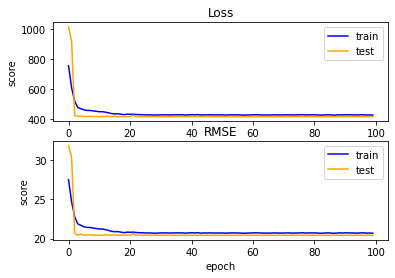

In [61]:
plot(history)

In [ ]:
img_size = [128, 128]
maxDelta = 0.2
contrast = [0.2, 0.5]
batch_size = 64

# pipeline
# image decoder
def img_decoder_new(path):
  img_file = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_file, channels=3)
  # resize images with pad to desired size
  img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
  # image normalization
  img = tf.cast(img, tf.float32) / 255.0
  # image reshape
  img = tf.reshape(img, [*img_size, 3])
  
  return img

# image augmentations
  # random flip
  # random brightness
  # random contrast
  # random hue
def img_flip_new(img):
  img = tf.image.random_flip_left_right(img)
  img = tf.reshape(img, [*img_size, 3])
  return img

def img_flip2_new(img):
  img = tf.image.random_flip_up_down(img)
  img = tf.reshape(img, [*img_size, 3])
  return img

def img_bri_new(img):
  img = tf.image.random_brightness(img, max_delta=maxDelta)
  img = tf.reshape(img, [*img_size, 3])
  return img

def img_contrast_new(img):
  img = tf.image.random_contrast(img, contrast[0], contrast[1])
  img = tf.reshape(img, [*img_size, 3])
  return img

def img_hue_new(img):
  img = tf.image.random_hue(img, max_delta=maxDelta)
  img = tf.reshape(img, [*img_size, 3])
  return img

In [ ]:
# # Training Only
train_images_2 = []
for i in tqdm(range(train.shape[0])):
   path = os.path.join(train_images_path, train_images_list[i])
   image = cv2.imread(path)
   image = image / 255
   image = cv2.resize(image, (224, 224))
  # image = img_flip_new(image)
  # image = img_bri_new(image)
  # image = img_contrast_new(image)
  # image = img_hue_new(image)
   train_images_2.append(image)
train_images_2 = np.array(train_images_2)  
print(train_images_2.shape)

In [ ]:

train_fea = model.predict(train_images_2)

In [ ]:
mlp = Sequential(layers = [
    Dense(units = 32, activation = 'relu', input_shape = (8192,)),
    Dropout(0.45),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 128, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.45),
    Dense(units = 4, activation = 'relu'),
    Dense(units = 1, activation = 'relu'),
])

mlp.summary()

In [ ]:
train_fea = train_fea.reshape(train_fea.shape[0], -1)
print(train_fea.shape)

In [ ]:
adam = Adam(learning_rate = 0.01)
reduce_lr = ReduceLROnPlateau(save_weights_only=True,
  monitor='val_root_mean_squared_error',
  mode='min',
  save_best_only=True)

mlp.compile(loss = "mse", optimizer = adam, metrics = RMSE())
predictor = mlp.fit(train_fea, train_label, validation_split = 0.2, epochs = 100, batch_size = 32, callbacks = [reduce_lr])